In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

# О проекте
Анализ доходности инвестиций в акции, криптовалюту и вклад.

## Данные
- **Акции**: [Kaggle: US Stocks & ETFs](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)
- **Криптовалюта**: [Kaggle: Cryptocurrency Data](https://www.kaggle.com/datasets/philmohun/cryptocurrency-financial-data)
- **Курс USD/RUB**: [Kaggle: USD/RUB](https://www.kaggle.com/datasets/fedesoriano/usd-rub-historical-data)
- **Ключевая ставка**: [ЦБ РФ](https://www.cbr.ru/hd_base/keyrate/)

## Параметры инвестирования: период, сумма и активы

In [2]:
start_date = '2016-09-01'
end_date = '2017-08-31'

cryptocurrency = 'bitcoin'
daily_investment = 1000
stocks = 'aapl'

In [3]:
crypto_tickers = {
    'tezos': 'XTZ',
    'binance-coin': 'BNB',
    'eos': 'EOS',
    'bitcoin': 'BTC',
    'tether': 'USDT',
    'xrp': 'XRP',
    'bitcoin-cash': 'BCH',
    'stellar': 'XLM',
    'litecoin': 'LTC',
    'ethereum': 'ETH',
    'cardano': 'ADA',
    'bitcoin-sv': 'BSV'
}

In [4]:
stock_names = {
    'aapl': 'Apple',
    'amzn': 'Amazon',
    'avgo': 'Broadcom',
    'cost': 'Costco',
    'gld': 'SPDR Gold Shares',  # Это ETF
    'goog': 'Alphabet (Google)',
    'googl': 'Alphabet (Google)',
    'jnj': 'Johnson & Johnson',
    'jpm': 'JPMorgan Chase',
    'ma': 'Mastercard',
    'msft': 'Microsoft',
    'nflx': 'Netflix',
    'nvda': 'NVIDIA',
    'orcl': 'Oracle',
    'pg': 'Procter & Gamble',
    'qqq': 'Invesco QQQ Trust',  # Это ETF
    'spy': 'SPDR S&P 500 ETF Trust',  # Это ETF
    'tsla': 'Tesla',
    'unh': 'UnitedHealth Group',
    'v': 'Visa',
    'voo': 'Vanguard S&P 500 ETF',  # Это ETF
    'wmt': 'Walmart',
    'xom': 'ExxonMobil'
}

## Загрузка и обратобка курса USD/RUB и конвертация в доллары

In [5]:
# Загрузка курса USD/RUB за период анализа
# Данные по USD/RUB содержат только рабочие дни, выходные исключены
exchange_rate = pd.read_csv('Data/USD_RUB.csv', parse_dates=['Date'], usecols=['Date', 'Price'])
exchange_rate = exchange_rate[(exchange_rate['Date'] >= start_date) & (exchange_rate['Date'] <= end_date)]
# разворачиваем список т.к. даты идут в обратном порядке
exchange_rate = exchange_rate.iloc[::-1].reset_index(drop=True)

In [6]:
# Высчитываем количество долларов по актуальному курсу
usd_quantity = exchange_rate.copy()
usd_quantity['Quantity'] = daily_investment / usd_quantity['Price'].astype(float)

# Анализ криптовалюты: подготовка данных, агрегация по месяцам, расчёт накоплений и долей

In [7]:
# Подготовка данных по криптовалюте для расчёта покупок
crypto_data = pd.read_csv('Data/consolidated_coin_data.csv')
crypto_data['Date'] = pd.to_datetime(crypto_data['Date'], format='%b %d, %Y')
crypto_data['Close'] = crypto_data['Close'].str.replace(',', '').astype(float)

crypto_data = crypto_data[crypto_data['Currency'] == cryptocurrency][['Date', 'Close']].iloc[::-1].dropna()
crypto_data = crypto_data[crypto_data['Date'].isin(exchange_rate['Date'])].reset_index(drop=True)

# Рассчитываем количество монет, купленных ежедневно
crypto_data['Daily_Amount'] = usd_quantity['Quantity'] / crypto_data['Close']
crypto_data['Month_Year'] = crypto_data['Date'].dt.to_period('M')

In [8]:
monthly_data_crypto = crypto_data.groupby('Month_Year')['Daily_Amount'].sum().reset_index()
monthly_data_crypto = monthly_data_crypto.rename(columns={'Daily_Amount':'Monthly_Amount'})

monthly_data_crypto['Month_Year'] = monthly_data_crypto['Month_Year'].dt.strftime('%b %Y')
monthly_data_crypto['Cumulative_Amount'] = monthly_data_crypto['Monthly_Amount'].cumsum()

total_cumulative = monthly_data_crypto['Cumulative_Amount'].iloc[-1]
monthly_data_crypto['Total_Cumulative_Perc'] = round((monthly_data_crypto['Monthly_Amount'] / total_cumulative * 100), 2)

## Визуализация накоплений криптовалюты: ежемесячный баланс и прирост

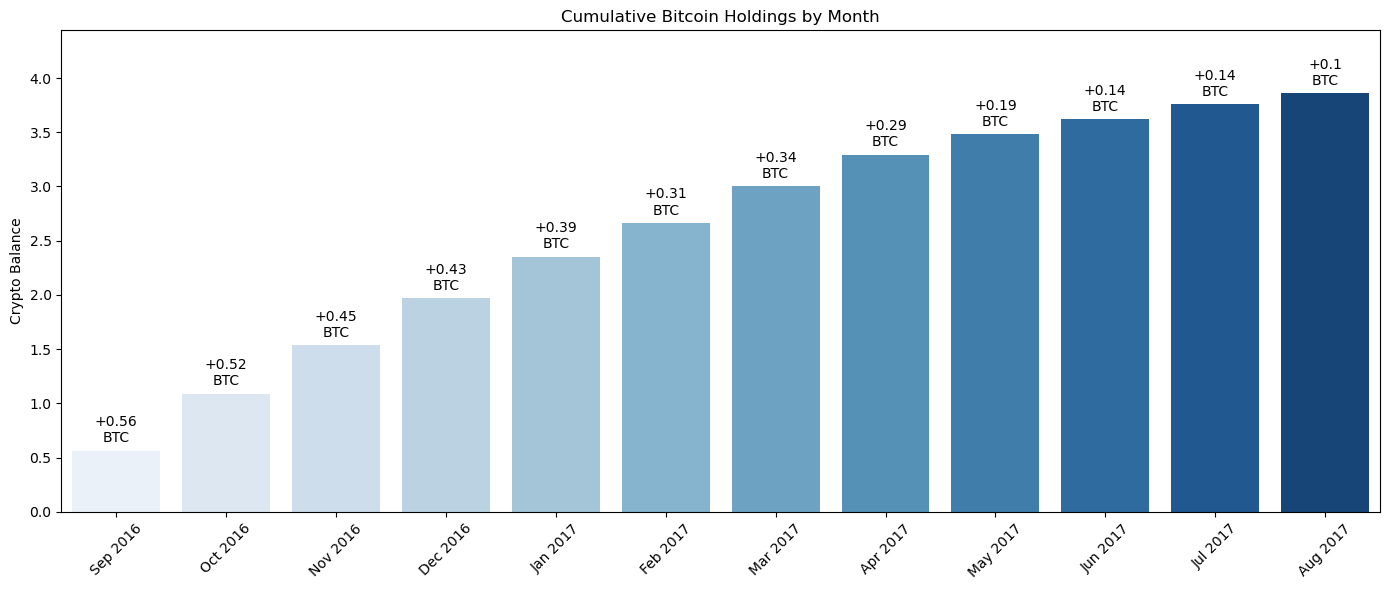

In [9]:
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Blues", n_colors=len(monthly_data_crypto))
sns.barplot(x='Month_Year', y='Cumulative_Amount', data=monthly_data_crypto, palette=palette, hue='Cumulative_Amount', legend=False)

# Добавляем значения над колонками
for i, row in monthly_data_crypto.iterrows():
    plt.text(
        i,  # Индекс колонки (по оси X)
        row['Cumulative_Amount'] + 0.05,  # Положение текста по Y (чуть выше вершины колонки)
        f"+{round((row['Monthly_Amount']),2)}\n{crypto_tickers[cryptocurrency]}",  # Текст (значение Monthly_Amount с 6 знаками после запятой) 
        ha='center',  # Горизонтальное выравнивание по центру
        va='bottom'  # Вертикальное выравнивание снизу
    )
# Устанавливаем ограничение оси Y
max_y = monthly_data_crypto['Cumulative_Amount'].max() # Максимальное значение на оси Y
plt.ylim(0, max_y * 1.15)

plt.title(f'Cumulative {cryptocurrency.title()} Holdings by Month')
plt.xlabel('')
plt.ylabel(f'Crypto Balance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f'Graph/Cumulative_{cryptocurrency.title()}_Amount_By_Month.png', dpi=1000, bbox_inches='tight')
plt.show()

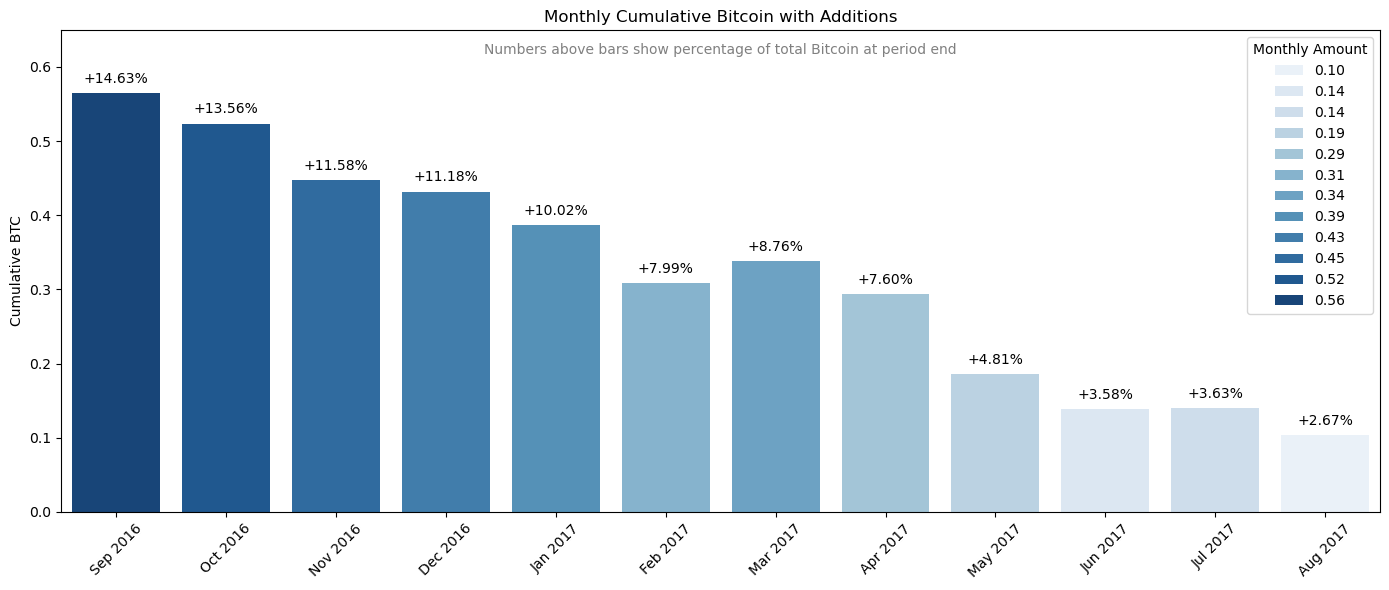

In [10]:
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Blues", n_colors=len(monthly_data_crypto))
ax = sns.barplot(x='Month_Year', y='Monthly_Amount', data=monthly_data_crypto, palette=palette, hue='Monthly_Amount',legend=False)

for i, row in monthly_data_crypto.iterrows():
    plt.text(
        i,  # Индекс колонки (по оси X)
        row['Monthly_Amount'] + 0.01,  # Положение текста по Y (чуть выше вершины колонки)
        f"+{row['Total_Cumulative_Perc']:.2f}%",  # Текст (значение Monthly_Amount с 6 знаками после запятой)
        ha='center',  # Горизонтальное выравнивание по центру
        va='bottom'  # Вертикальное выравнивание снизу
    )

plt.ylim(0, monthly_data_crypto['Monthly_Amount'].max() * 1.15)

plt.title(f'Monthly Cumulative {cryptocurrency.title()} with Additions')
plt.xlabel('')
plt.ylabel(f'Cumulative {crypto_tickers[cryptocurrency]}')
plt.xticks(rotation=45)

# Добавляем подпись по центру
plt.text(0.5, 0.95, f'Numbers above bars show percentage of total {cryptocurrency.title()} at period end', 
         transform=plt.gca().transAxes, fontsize=10, ha='center', color='gray')

plt.legend(labels=[f"{val:.2f}" for val in monthly_data_crypto['Monthly_Amount'].sort_values()],title='Monthly Amount', handles=ax.patches)

plt.tight_layout()
plt.savefig(f'Graph/Monthly_Amount_{cryptocurrency.title()}.png', dpi=1000, bbox_inches='tight')
plt.show()

# Анализ инвестиций в акции: подготовка, ежемесячная агрегация, накопления и доли

In [11]:
# Подготовка данных по акциям для расчёта покупок
stocks_data = pd.read_csv(f'Data/Stocks/{stocks}.us.txt')

stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
stocks_data['Close'] = stocks_data['Close'].astype(float)

stocks_data = stocks_data[stocks_data['Date'].isin(exchange_rate['Date'])].reset_index(drop=True)
stocks_data = stocks_data[['Date', 'Close']].dropna()

stocks_data = stocks_data.merge(usd_quantity[['Date', 'Quantity']], on='Date', how='left')

stocks_data['Daily_Amount'] = usd_quantity['Quantity'] / stocks_data['Close']
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'], format='%Y-%m-%d')
# Создаем новую колонку с годом и месяцем для группировки ыыы
stocks_data['Month_Year'] = stocks_data['Date'].dt.to_period('M')

In [12]:
monthly_data_stocks = stocks_data.groupby('Month_Year')['Daily_Amount'].sum().reset_index()
monthly_data_stocks = monthly_data_stocks.rename(columns={'Daily_Amount':'Monthly_Amount'})
monthly_data_stocks['Monthly_Amount'] = monthly_data_stocks['Monthly_Amount'].round()

monthly_data_stocks['Month_Year'] = monthly_data_stocks['Month_Year'].dt.strftime('%b %Y')

monthly_data_stocks['Cumulative_Amount'] = monthly_data_stocks['Monthly_Amount'].cumsum()
total_cumulative_c = monthly_data_stocks['Cumulative_Amount'].iloc[-1].round()
monthly_data_stocks['Total_Cumulative_Perc'] = round((monthly_data_stocks['Monthly_Amount'] / total_cumulative_c) * 100, 2)

## Визуализация инвестиций в акции: ежемесячный баланс и динамика цен

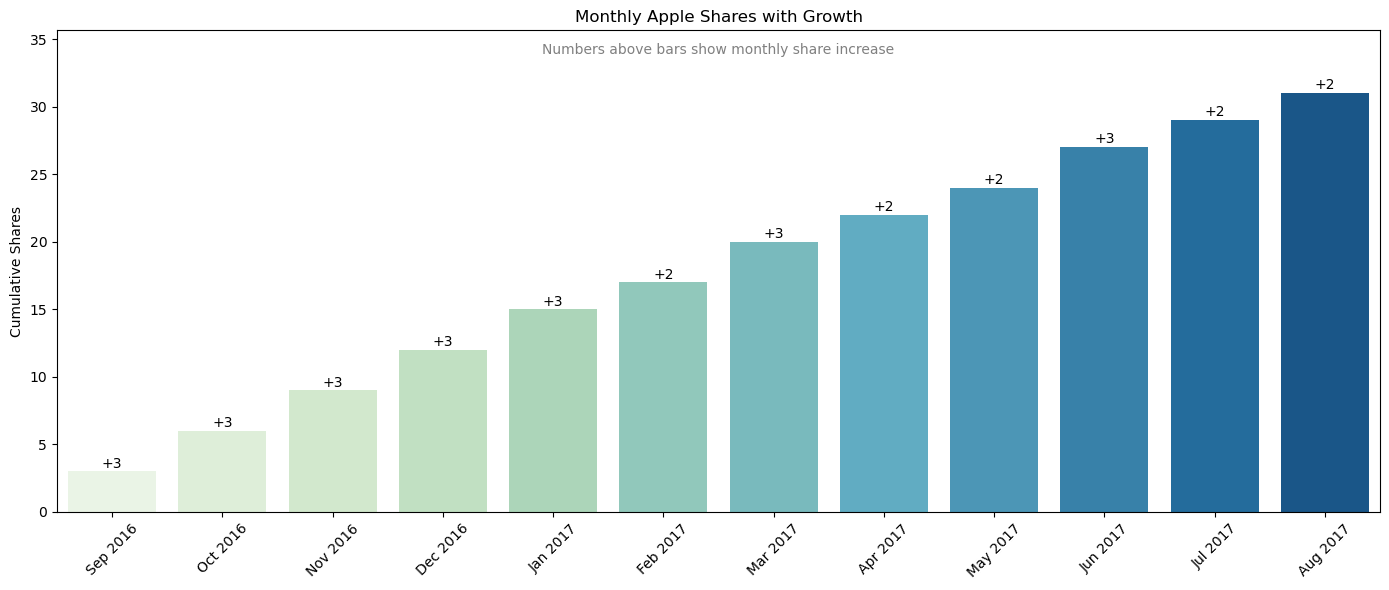

In [13]:
plt.figure(figsize=(14, 6))
palette = sns.color_palette("GnBu", n_colors=len(monthly_data_stocks))
sns.barplot(x='Month_Year', y='Cumulative_Amount', data=monthly_data_stocks, palette=palette, hue='Cumulative_Amount', legend=False)

for i, row in monthly_data_stocks.iterrows():
    plt.text(
        i,  # Индекс колонки (по оси X)
        row['Cumulative_Amount'] + 0.05,  # Положение текста по Y (чуть выше вершины колонки)
        f"+{round((row['Monthly_Amount']))}",  # Текст (значение Monthly_Amount с 6 знаками после запятой) 
        ha='center',  # Горизонтальное выравнивание по центру
        va='bottom'  # Вертикальное выравнивание снизу
    )

plt.ylim(0, monthly_data_stocks['Cumulative_Amount'].max() * 1.15)

plt.title(f'Monthly {stock_names[stocks]} Shares with Growth')
plt.xlabel('')
plt.ylabel('Cumulative Shares')
plt.xticks(rotation=45)

plt.text(0.5, 0.95, 'Numbers above bars show monthly share increase', 
         transform=plt.gca().transAxes, fontsize=10, ha='center', color='gray') # Добавляем подпись по центру

plt.tight_layout()
plt.savefig(f'Graph/Cumulative_{stocks.upper()}_Amount_By_Month.png', dpi=1000, bbox_inches='tight')
plt.show()

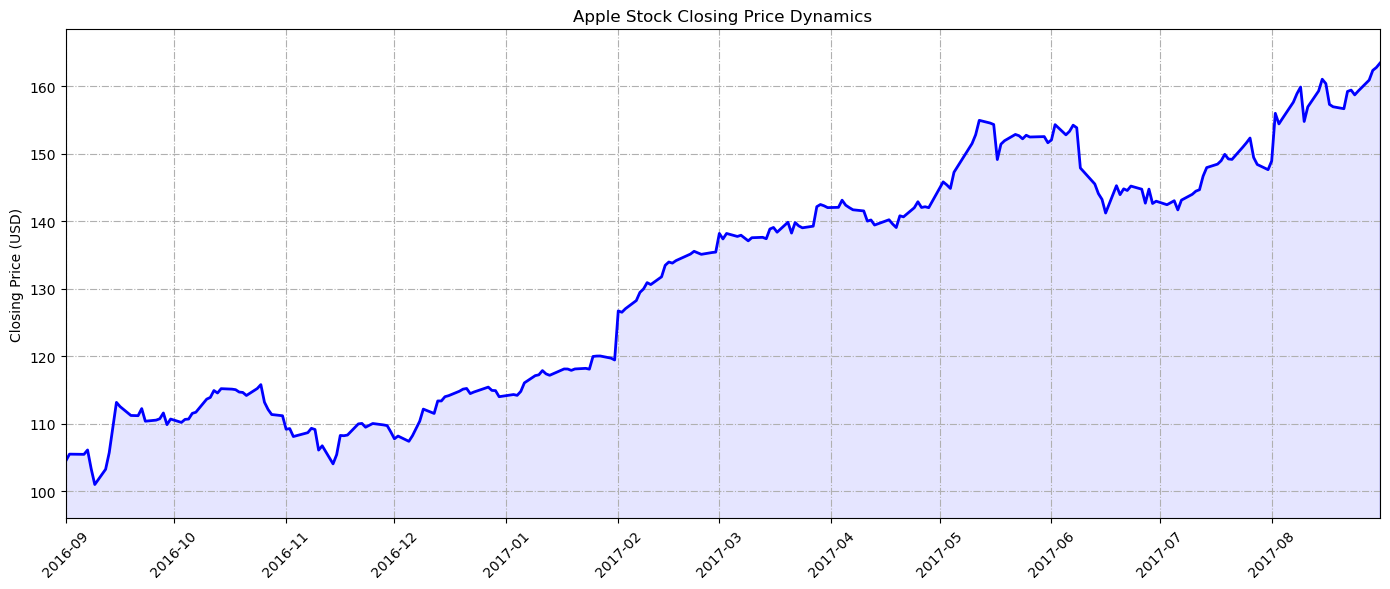

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(stocks_data['Date'], stocks_data['Close'], color='blue', linewidth=2)

# Добавляем заливку под графиком
plt.fill_between(stocks_data['Date'], stocks_data['Close'], color='blue', alpha=0.1)

plt.title(f'{stock_names[stocks]} Stock Closing Price Dynamics')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='dashdot')

# Фиксируем шкалу
plt.ylim(stocks_data['Close'].min() - 5, stocks_data['Close'].max() + 5)
plt.xlim(stocks_data['Date'].iloc[0],stocks_data['Date'].iloc[-1])

plt.tight_layout()
plt.savefig(f'Graph/{stocks.upper()} stock closing price dynamics.png', dpi=1000, bbox_inches='tight')
plt.show()

# Динамика ключевой ставки: график с акцентом на выбранный интервал

In [15]:
# Подключаем дата-сет с ключевой ставкой и разворачиваем список т.к. даты идут в обратном порядке
keyrate = pd.read_excel('Data/keyrate.xlsx').iloc[::-1].reset_index(drop=True)

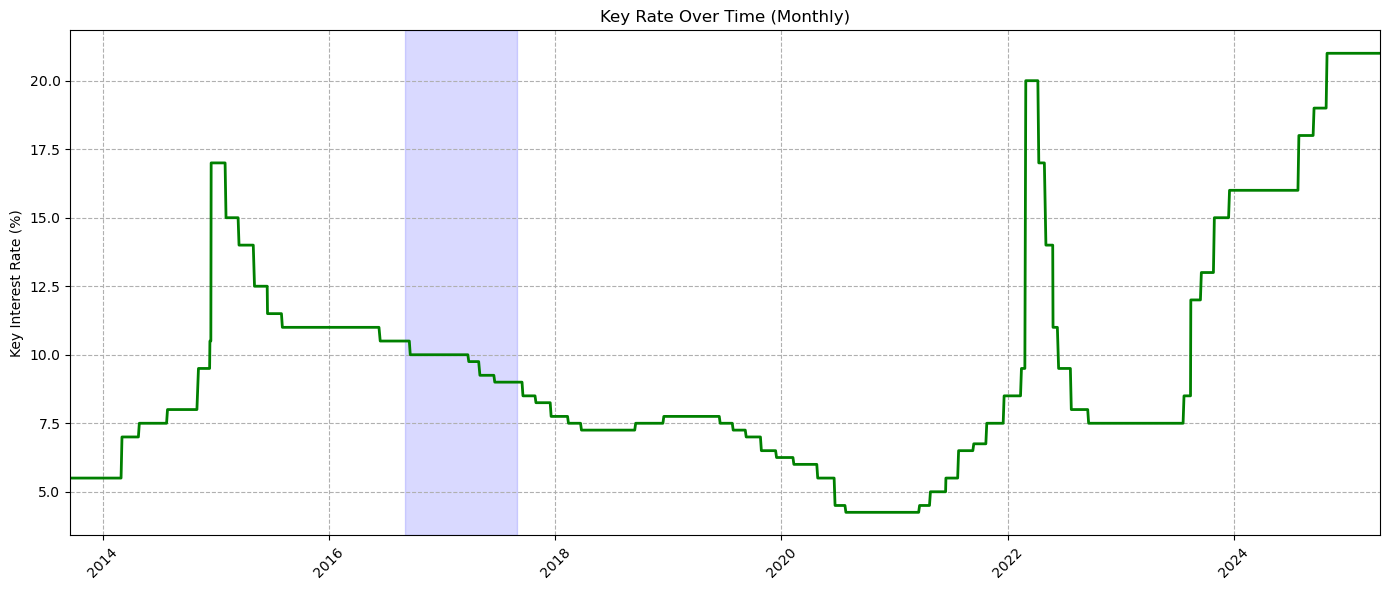

In [16]:
plt.figure(figsize=(14,6))
plt.plot(keyrate['Date'], keyrate['Keyrate'], color='green', linewidth=2)

plt.title('Key Rate Over Time (Monthly)')
plt.ylabel('Key Interest Rate (%)')
plt.xlim(keyrate['Date'].iloc[0],keyrate['Date'].iloc[-1])
plt.xticks(rotation=45)
plt.grid(True, linestyle='--')

# Выделяем выбранный период на графике
plt.axvspan(start_date, end_date, color='blue', alpha=0.15)

plt.tight_layout()
plt.savefig(f'Graph/Keyrate_By_Month.png', dpi=1000, bbox_inches='tight')
plt.show()

# Анализ рублевого вклада: расчёт накоплений с учётом ключевой ставки

In [17]:
# Синхронизация keyrate с exchange_rate
deposit = pd.DataFrame({'Date': exchange_rate['Date']})
deposit = deposit.merge(keyrate[['Date', 'Keyrate']], on='Date', how='left')

# Заполняем пропуски вперед (ставка сохраняется до следующего изменения)
deposit['Keyrate'] = deposit['Keyrate'].ffill()

# Расчет вклада
deposit['Deposit_Amount'] = 0.0
for i in range(len(deposit)):
    if i == 0:
        deposit.loc[i, 'Deposit_Amount'] = daily_investment
    else:
        prev_amount = deposit.loc[i-1, 'Deposit_Amount']
        rate = deposit.loc[i, 'Keyrate'] / 100  # Ставка в долях
        new_amount = prev_amount * (1 + rate / 365) + daily_investment
        deposit.loc[i, 'Deposit_Amount'] = round(new_amount,2)

# Итоги для вклада
final_deposit_amount = deposit['Deposit_Amount'].iloc[-1] #финальная доходность
total_invested = len(deposit) * daily_investment  #инвестировано рубл
deposit_profitability = ((final_deposit_amount - total_invested) / total_invested) * 100 #итоговая доходность в %

# Сравнительный анализ доходности: вклад, криптовалюта и акции

In [18]:
# Переводим в рубли криптовалюту и акции
crypto_data['Rub_Amount'] = crypto_data['Daily_Amount'].cumsum() * crypto_data['Close'] * exchange_rate['Price']
stocks_data['Rub_Amount'] = stocks_data['Daily_Amount'].cumsum() * stocks_data['Close'] * exchange_rate['Price']

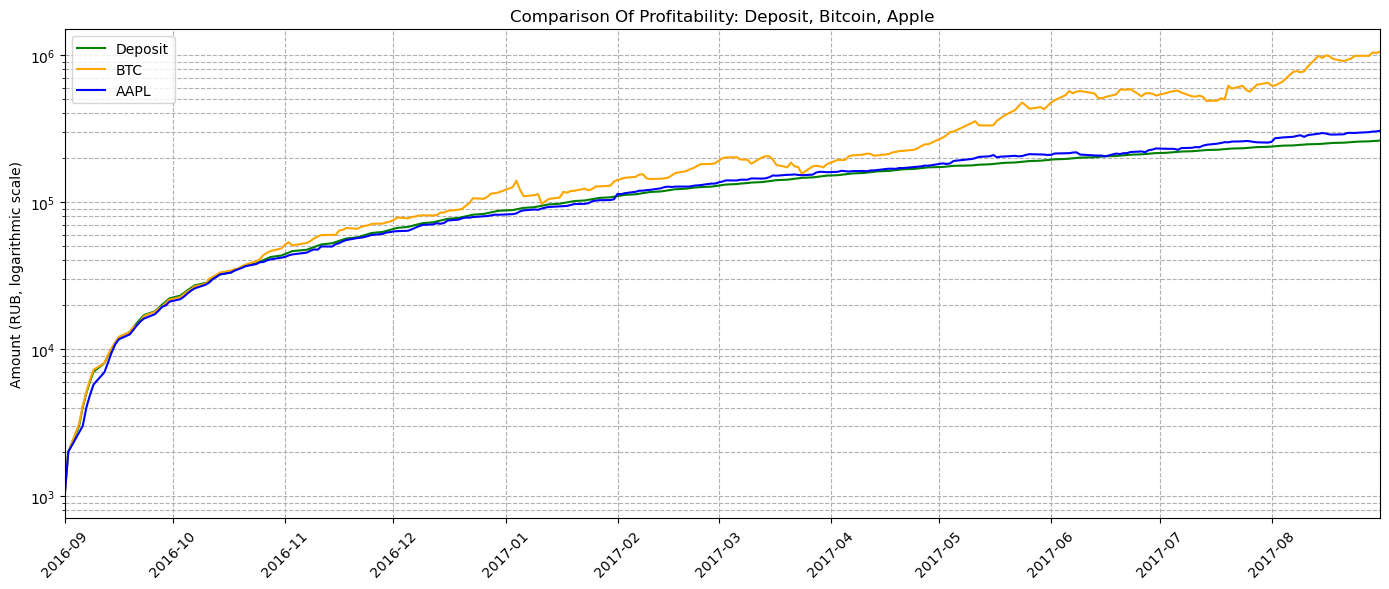

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(deposit['Date'], deposit['Deposit_Amount'], label='Deposit', color='green', linewidth=1.5)
plt.plot(crypto_data['Date'], crypto_data['Rub_Amount'], label=f'{crypto_tickers[cryptocurrency]}', color='orange', linewidth=1.5)
plt.plot(stocks_data['Date'], stocks_data['Rub_Amount'], label=f'{stocks.upper()}', color='blue', linewidth=1.5)
plt.yscale('log')  # Логарифмическая шкала из-за разницы в доходности
plt.xlim(crypto_data['Date'].iloc[0], crypto_data['Date'].iloc[-1])

plt.xlabel('')
plt.ylabel('Amount (RUB, logarithmic scale)')
plt.title(f'Comparison Of Profitability: Deposit, {cryptocurrency.title()}, {stock_names[stocks]}')

plt.legend()
plt.grid(True, which="both", ls="--")
plt.xticks(rotation=45)


plt.tight_layout()
plt.savefig('Graph/comparison_plot.png', dpi=1000, bbox_inches='tight')
plt.show()

# 📌 Финальные итоги: расчёт доходности по вкладу, криптовалюте и акциям

In [20]:
# Итоги для вклада
final_deposit_amount = deposit['Deposit_Amount'].iloc[-1]
total_invested = len(deposit) * daily_investment
deposit_profitability = ((final_deposit_amount - total_invested) / total_invested) * 100

# Итоги для криптовалюты
final_cryptocurrency_amount = monthly_data_crypto['Cumulative_Amount'].iloc[-1]
final_cryptocurrency_price = crypto_data['Close'].iloc[-1]
final_usd_rub = exchange_rate['Price'].iloc[-1]
cryptocurrency_final_amount = final_cryptocurrency_amount * final_cryptocurrency_price * final_usd_rub
cryptocurrency_profitability = ((cryptocurrency_final_amount - total_invested) / total_invested) * 100

# Итоги для акций
final_stock_amount = monthly_data_stocks['Cumulative_Amount'].iloc[-1]
final_stock_price = stocks_data['Close'].iloc[-1]
stock_final_amount = final_stock_amount * final_stock_price * final_usd_rub
stock_profitability = ((stock_final_amount - total_invested) / total_invested) * 100

total_days = len(deposit)  # Количество дней
total_invested = total_days * daily_investment  # Общая сумма инвестиций

In [21]:
def format_day(n: int) -> str:
    """Возвращает число дней с правильным склонением ('день', 'дня', 'дней')."""
    if 11 <= n % 100 <= 14:
        return f"{n} дней"
    elif n % 10 == 1:
        return f"{n} день"
    elif 2 <= n % 10 <= 4:
        return f"{n} дня"
    else:
        return f"{n} дней"

In [22]:
# Markdown-вывод
Markdown(f"""
# Вывод результатов

**Общая сумма инвестиций (руб.):** `{total_invested} руб.`  
**Количество дней:** `{format_day(len(exchange_rate))}`

## Сравнение доходности:
- **Вклад:**  
  - Итоговая сумма: `{round(final_deposit_amount)} руб.`  
  - Доходность: `{round(deposit_profitability, 2)}%` 
- **{cryptocurrency.title()}:**  
  - Итоговое количество монет: `{round(final_cryptocurrency_amount,2)} {cryptocurrency}`
  - Итоговая сумма: `{round(cryptocurrency_final_amount)} руб.`  
  - Доходность: `{round(cryptocurrency_profitability, 2)}%`  
- **{stock_names[stocks]}:**  
  - Итоговое количество акций: `{round(final_stock_amount)}`
  - Итоговая сумма: `{round(stock_final_amount)} руб.`  
  - Доходность: `{round(stock_profitability, 2)}%`
""")


# Вывод результатов

**Общая сумма инвестиций (руб.):** `253000 руб.`  
**Количество дней:** `253 дня`

## Сравнение доходности:
- **Вклад:**  
  - Итоговая сумма: `261443 руб.`  
  - Доходность: `3.34%` 
- **Bitcoin:**  
  - Итоговое количество монет: `3.86 bitcoin`
  - Итоговая сумма: `1053339 руб.`  
  - Доходность: `316.34%`  
- **Apple:**  
  - Итоговое количество акций: `31`
  - Итоговая сумма: `293842 руб.`  
  - Доходность: `16.14%`
